In [1]:
import os
import sys

# Set environment variable for scipy array API compatibility
os.environ["SCIPY_ARRAY_API"] = "1"

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap

from scripts.load_data import load_clean_data_for_modeling


/home/abel/Desktop/Projects/ACIS-Insurance-Analytics/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and inspect data
df, X, y = load_clean_data_for_modeling()
print("TotalClaims stats:\n", df['TotalClaims'].describe())
print("Non-zero TotalClaims rows:", len(df[df['TotalClaims'] > 0]))

# Create HasClaim column immediately
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
y = df['HasClaim']  # Set y to HasClaim for consistency

Initial row count: 1000098
Pre-processing TotalClaims stats:\n count    1.000098e+06
mean     6.486119e+01
std      2.384075e+03
min     -1.200241e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.930921e+05
Name: TotalClaims, dtype: float64
Post-cleaning row count: 1000098
Post-cleaning TotalClaims stats:\n count    1.000098e+06
mean     6.486119e+01
std      2.384075e+03
min     -1.200241e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.930921e+05
Name: TotalClaims, dtype: float64
Post-outlier removal row count: 352427
Post-outlier removal TotalClaims stats:\n count    352427.000000
mean          2.117392
std          80.614683
min        -635.480000
25%           0.000000
50%           0.000000
75%           0.000000
max       16708.771930
Name: TotalClaims, dtype: float64
TotalClaims stats:
 count    352427.000000
mean          2.117392
std          80.614683
min        -635.480000
25%           0.000000
50%           0

In [3]:
# Feature engineering and encoding
features = ['SumInsured', 'CleanCoverCategory', 'Province', 'VehicleType', 'RegistrationYear', 
            'CalculatedPremiumPerTerm', 'Cylinders', 'cubiccapacity', 'kilowatts']

data = df[features + ['HasClaim']].copy()
X = data[features].copy()
y = data['HasClaim']

# Apply one-hot encoding
X = pd.get_dummies(X, columns=['CleanCoverCategory', 'Province', 'VehicleType'], drop_first=True)

# Convert numeric columns
for col in ['SumInsured', 'CalculatedPremiumPerTerm', 'Cylinders', 'cubiccapacity', 'kilowatts']:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Log and drop NaNs
print(f"Rows before NaN drop: {len(X)}")
X = X.dropna()
y = y.loc[X.index]
print(f"Rows after NaN drop: {len(X)}, Dropped: {len(data) - len(X)}")

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Rows before NaN drop: 352427
Rows after NaN drop: 352427, Dropped: 0


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_auc_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Model building with class weight
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    y_pred = (y_prob > optimal_threshold).astype(int)
    print(f"{name} y_pred distribution: {np.bincount(y_pred, minlength=2)}")
    print(f"{name} claim_prob min/max: {y_prob.min():.4f}, {y_prob.max():.4f}")
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    results[name] = {"Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": roc_auc}

# Print results
print("Model Evaluation:")
for name, metrics in results.items():
    print(f"{name} - Accuracy: {metrics['Accuracy']:.2f}, F1-Score: {metrics['F1-Score']:.2f}, "
          f"ROC-AUC: {metrics['ROC-AUC']:.2f}")

/home/abel/Desktop/Projects/ACIS-Insurance-Analytics/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression y_pred distribution: [70393    93]
Logistic Regression claim_prob min/max: 0.0000, 0.9778
Random Forest y_pred distribution: [69703   783]
Random Forest claim_prob min/max: 0.0000, 0.9845
XGBoost y_pred distribution: [69530   956]
XGBoost claim_prob min/max: 0.0000, 1.0000
Model Evaluation:
Logistic Regression - Accuracy: 1.00, F1-Score: 0.02, ROC-AUC: 0.93
Random Forest - Accuracy: 0.99, F1-Score: 0.03, ROC-AUC: 0.88
XGBoost - Accuracy: 0.99, F1-Score: 0.02, ROC-AUC: 0.92


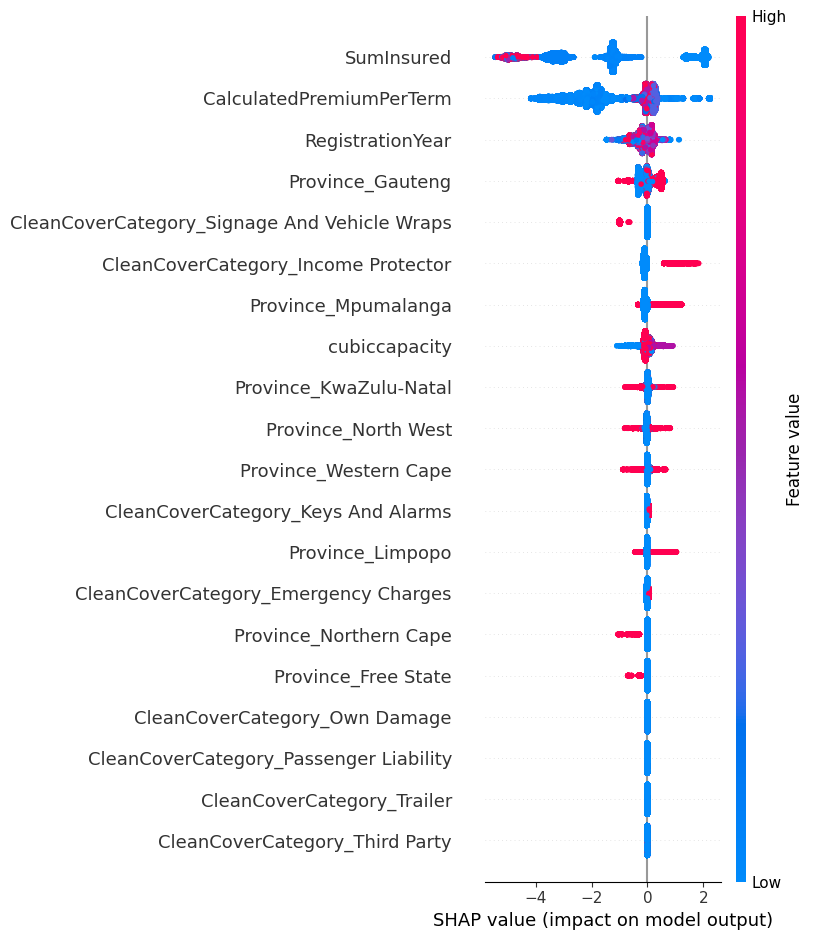

In [12]:
# Feature importance analysis using SHAP (for XGBoost as an example)
if len(X_train) > 0 and len(y_train) > 0:
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train, y_train)
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)

In [11]:
# Update premium calculation with scaled claim_prob
claim_prob = model.predict_proba(X_test)[:, 1] * 100  # Ensure scaling factor
severity = df['TotalClaims'].mean()  # 2.117392
expense_loading = 10
profit_margin = 5
premiums = (claim_prob * severity) + expense_loading + profit_margin
print("Sample Risk-Based Premiums min/max:", premiums.min().round(2), premiums.max().round(2))
print("Sample Risk-Based Premiums:", premiums[:5].round(2))

Sample Risk-Based Premiums min/max: 15.0 226.74
Sample Risk-Based Premiums: [15. 15. 15. 15. 15.]
